# Demo funnel

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr

import funnel as fn
import operators as ops
import variable_defs

In [3]:
import utils
cluster, client = utils.get_ClusterClient()
cluster.scale(24) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.60:34027 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Compute epoch mean

In [4]:
# this is a fragile way to define functions: don't do it this way, use a module
def epoch_mean_present_day(ds):
    return ds.sel(time=slice('1990-01-01', '2015-01-15')).mean('time')

def subset(ds):
    return ds.isel(nlat=slice(0, 20), nlon=slice(0, 20))

coll = fn.Collection(
    esm_collection_json='data/campaign-cesm2-cmip6-timeseries.json',
    postproccess=[epoch_mean_present_day],  
    query={'experiment': 'historical', 'stream': 'pop.h'},
    cache_dir=os.environ['TMPDIR'],
    persist=True,
    cdf_kwargs=dict(chunks={'time': 4}, decode_coords=False), 
    preprocess=subset,
)


ds_list = []
for v in ['FG_CO2', 'SST', 'pCFC11']:
    dsets = coll.dsets(variable=v, clobber=False, prefer_derived=True)
    assert len(dsets) == 1
    _, ds = dsets.popitem()
    ds_list.append(ds[[v]])

ds = xr.merge(ds_list)
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


<xarray.Dataset>
Dimensions:    (member_id: 11, nlat: 20, nlon: 20, z_t: 60)
Coordinates:
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    FG_CO2     (member_id, nlat, nlon) float32 nan nan nan ... 0.001338 0.001355
    SST        (member_id, nlat, nlon) float32 nan nan nan ... -1.613 -1.606
    pCFC11     (member_id, z_t, nlat, nlon) float32 nan nan nan ... nan nan nan

## Compute timeseries

In [5]:
experiments = ['historical', 'SSP5-8.5']

coll = fn.Collection(
    esm_collection_json='data/campaign-cesm2-cmip6-timeseries.json',
    postproccess=[ops.global_mean, ops.resample_ann],
    postproccess_kwargs=[dict(normalize=False), {}],
    query={'experiment': experiments, 'stream': 'pop.h'},
    cache_dir=os.environ['TMPDIR'],
    persist=True,
    cdf_kwargs=dict(chunks={'time': 4},), 
)

dsets = {}
for v in ['FG_CO2',]:
    dsets.update(coll.dsets(variable=v, clobber=False, prefer_derived=True))
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


{'ocn.SSP5-8.5.pop.h': <xarray.Dataset>
 Dimensions:                 (lat_aux_grid: 395, member_id: 3, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 86, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
 Coordinates: (12/13)
   * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
   * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
   * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
   * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
     ULONG                   (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
   * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
     ...                      ...
   * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
   * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
     TLAT                    (nlat, nlon) float64 -79

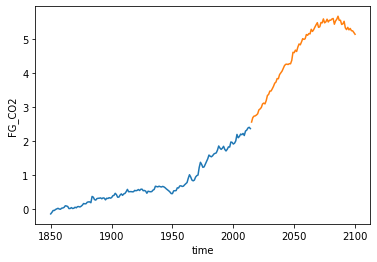

In [6]:
for experiment in experiments:
    key = f'ocn.{experiment}.pop.h'
    ds = dsets[key]
    ds.FG_CO2.mean('member_id').plot(label=experiment)

In [16]:
isinstance(x, slice)

True